# This is the final project in the frames of the "Applied Data Science Capstone"

The concept of this project is to compare the neighborhoods of New York and Toronto cities. Some analysis has already been done in Week 3, so it won't be so difficult.
Similarities and differences between the neighborhoods of a city or the two cities can be found in terms of shops and others.

#### Exploring the data

The data of the project will be taken by the cloud of IBM for New York city and from Wikipedia for Toronto. The process will be the same as in Week 3.

## I start with some package installation
### Firstly, I install folium and secondly geopy
### If I need other packages, I will install later

In [19]:
!conda install -c conda-forge folium=0.5.0 --yes

Solving environment: done

# All requested packages already installed.



In [20]:
!conda install -c conda-forge geopy --yes

Solving environment: done

# All requested packages already installed.



In [22]:
import numpy as np
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json # library to handle JSON files
from bs4 import BeautifulSoup 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


# Now I must read the data and clean. Then, I create a table.

## I start with Toronto
I use a url that contains the neighborhoods in Toronto. I use Beautiful soup in order to "soup" the data. The table that I want to create contains three columns: Postal Code, Borough and Neighborhood. If there is no assignment, I skip it.
Next, I use a file which has been provided by IBM in Week 3 that contains the geospatial coordinates. I read the csv file using pandas. Then, I merge the two tables according to the Postal code. Furthermore, I make a change on the name of the column that I will use to merge the tables.

In [23]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"

data  = requests.get(url).text
soup = BeautifulSoup(data, 'html5lib')

table = soup.find('table')
contents = []

# Getting all rows
for row in table.find_all('td'):
    cell = {}
    if row.span.text == 'Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        contents.append(cell)
        
# Creating the dataframe
df = pd.DataFrame(contents)

# Changing some values to more comprehensive names
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

# coordinates from a given file
!wget -q -O 'Geospatial_Coordinates.csv' https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs_v1/Geospatial_Coordinates.csv
toronto_coordinates = pd.read_csv('Geospatial_Coordinates.csv')

#rename of the column
toronto_coordinates.rename(columns={'Postal Code':'PostalCode'}, inplace=True)

# merge of the tables
toronto = pd.merge(df, toronto_coordinates, on="PostalCode")

# I see the first 10 rows
toronto.head(10)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494
5,M9A,Etobicoke,Islington Avenue,43.667856,-79.532242
6,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
7,M3B,North York,Don Mills North,43.745906,-79.352188
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937


## Samilar...but easier process for New York
I use a json file that contains the neighborhoods in New York. The table that I want to create contains three columns: Borough, Neighborhood, Latitude and Longitude.
I read the json file using the command with.

In [24]:
!wget -q -O 'newyork_data.json' https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json
    
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
neighborhoods_data = newyork_data['features']

column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
newyork = pd.DataFrame(columns=column_names)

for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    newyork = newyork.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

# I see the first 10 rows
newyork.head(10)

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585
5,Bronx,Kingsbridge,40.881687,-73.902818
6,Manhattan,Marble Hill,40.876551,-73.910660
7,Bronx,Woodlawn,40.898273,-73.867315
8,Bronx,Norwood,40.877224,-73.879391
9,Bronx,Williamsbridge,40.881039,-73.857446


## Below I visualize with different colors the different boroughs in New York
### Next, I show the number of neighborhoods per borough

In [25]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(newyork['Latitude'], newyork['Longitude'], newyork['Borough'], newyork['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [26]:
newyork['Borough'].unique()

array(['Bronx', 'Manhattan', 'Brooklyn', 'Queens', 'Staten Island'],
      dtype=object)

In [27]:
newyork[newyork['Borough']=='Queens']['Neighborhood'].unique()

array(['Astoria', 'Woodside', 'Jackson Heights', 'Elmhurst',
       'Howard Beach', 'Corona', 'Forest Hills', 'Kew Gardens',
       'Richmond Hill', 'Flushing', 'Long Island City', 'Sunnyside',
       'East Elmhurst', 'Maspeth', 'Ridgewood', 'Glendale', 'Rego Park',
       'Woodhaven', 'Ozone Park', 'South Ozone Park', 'College Point',
       'Whitestone', 'Bayside', 'Auburndale', 'Little Neck', 'Douglaston',
       'Glen Oaks', 'Bellerose', 'Kew Gardens Hills', 'Fresh Meadows',
       'Briarwood', 'Jamaica Center', 'Oakland Gardens', 'Queens Village',
       'Hollis', 'South Jamaica', 'St. Albans', 'Rochdale',
       'Springfield Gardens', 'Cambria Heights', 'Rosedale',
       'Far Rockaway', 'Broad Channel', 'Breezy Point', 'Steinway',
       'Beechhurst', 'Bay Terrace', 'Edgemere', 'Arverne',
       'Rockaway Beach', 'Neponsit', 'Murray Hill', 'Floral Park',
       'Holliswood', 'Jamaica Estates', 'Queensboro Hill', 'Hillcrest',
       'Ravenswood', 'Lindenwood', 'Laurelton', 'Lefra

In [28]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York city are {}, {}.'.format(latitude, longitude))

new_map = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, borough, neighborhood in zip(newyork['Latitude'], newyork['Longitude'], newyork['Borough'], newyork['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    if borough=='Bronx':
        check_color='red'
    elif borough=='Manhattan':
        check_color='green'
    elif borough=='Brooklyn':
         check_color='black'
    elif borough=='Queens':
        check_color='brown'
    else:
        check_color='blue'
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=check_color,
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(new_map)

new_map

The geograpical coordinate of New York city are 40.7127281, -74.0060152.


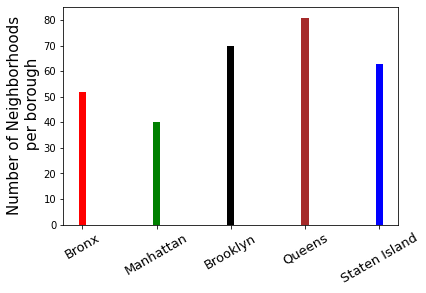

In [29]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

number_of_neighborhoods_NY = []
for x in newyork['Borough'].unique():
    number_of_neighborhoods_NY.append(len(newyork[newyork['Borough']==x]['Neighborhood'].unique()))

gs = gridspec.GridSpec(1, 1)
ax = plt.subplot(gs[0])

colors = ['red','green','black','brown','blue']
x = np.arange(5)
for i in range(len(x)):
    ax.bar(x[i],number_of_neighborhoods_NY[i],width=0.1,color=colors[i])

ax.set_xticks(x)
ax.set_xticklabels(newyork['Borough'].unique(),fontsize='13',rotation=30)
ax.set_ylabel('Number of Neighborhoods\n     per borough', fontsize=15)

plt.show()

## Same for Toronto

In [30]:
address = 'Toronto'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto['Latitude'], toronto['Longitude'], toronto['Borough'], toronto['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

The geograpical coordinate of New York City are 43.6534817, -79.3839347.


In [31]:
toronto['Borough'].unique()

array(['North York', 'Downtown Toronto', "Queen's Park", 'Etobicoke',
       'Scarborough', 'East York', 'York', 'East Toronto', 'West Toronto',
       'East York/East Toronto', 'Central Toronto', 'Mississauga',
       'Downtown Toronto Stn A', 'Etobicoke Northwest',
       'East Toronto Business'], dtype=object)

In [211]:
address = 'Toronto'

borough_colors = {"North York":"red",
                  "Downtown Toronto":"blue",
                  "Queen's Park":"green",
                  "Etobicoke":"black",
                  "Scarborough":"yellow",
                  "East York":"purple",
                  "York":"lightblue",
                  "East Toronto":"brown",
                  "West Toronto":"orange",
                  "East York/East Toronto":"grey",
                  "Central Toronto":"pink",
                  "Mississauga":"cyan",
                  "Downtown Toronto Stn A":"darkcyan",
                  "Etobicoke Northwest":"gold",
                  "East Toronto Business":"navy"}

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

new_map = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, borough, neighborhood in zip(toronto['Latitude'], toronto['Longitude'], toronto['Borough'], toronto['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    if borough in borough_colors.keys():
        check_color=borough_colors[borough]
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=check_color,
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(new_map)

new_map

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


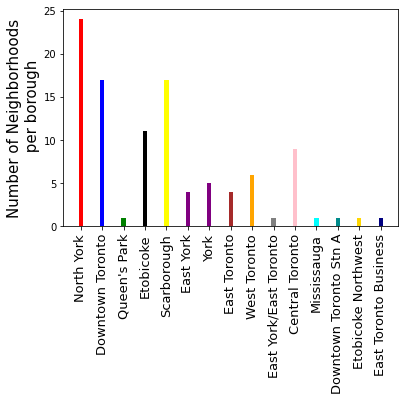

In [33]:
number_of_neighborhoods_Toronto= []
for x in toronto['Borough'].unique():
    number_of_neighborhoods_Toronto.append(len(toronto[toronto['Borough']==x]['Neighborhood'].unique()))

gs = gridspec.GridSpec(1, 1)
ax = plt.subplot(gs[0])

x = np.arange(len(number_of_neighborhoods_Toronto))
boroughs_toronto = toronto['Borough'].unique()
for i in range(len(x)):
    if boroughs_toronto[i] in borough_colors.keys():
        check_color=borough_colors[boroughs_toronto[i]]
    ax.bar(x[i],number_of_neighborhoods_Toronto[i],width=0.2,color=check_color)

ax.set_xticks(x)
ax.set_xticklabels(toronto['Borough'].unique(),fontsize='13', rotation=90)
ax.set_ylabel('Number of Neighborhoods\n     per borough', fontsize=15)

plt.show()

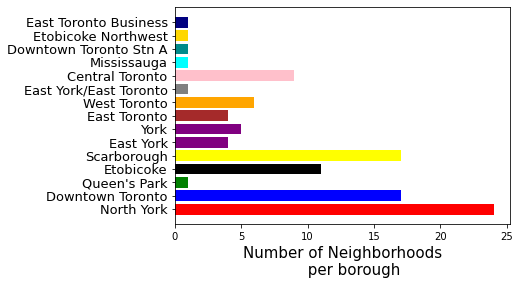

In [34]:
number_of_neighborhoods_Toronto= []
for x in toronto['Borough'].unique():
    number_of_neighborhoods_Toronto.append(len(toronto[toronto['Borough']==x]['Neighborhood'].unique()))

gs = gridspec.GridSpec(1, 1)
ax = plt.subplot(gs[0])

y = np.arange(len(number_of_neighborhoods_Toronto))
boroughs_toronto = toronto['Borough'].unique()
for i in range(len(y)):
    if boroughs_toronto[i] in borough_colors.keys():
        check_color=borough_colors[boroughs_toronto[i]]
    ax.barh(y[i],number_of_neighborhoods_Toronto[i],color=check_color)

ax.set_yticks(y)
ax.set_yticklabels(toronto['Borough'].unique(),fontsize='13')
ax.set_xlabel('Number of Neighborhoods\n     per borough', fontsize=15)

plt.show()

## Here I check Manhattan, i order to start checking all boroughs later

In [35]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    
    
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)



manhattan_data = newyork[newyork['Borough'] == 'Manhattan'].reset_index(drop=True)

CLIENT_ID = 'EX2QJNXTN1YYBYD2KWZLVRSEOZTA5BMSBXUOF0EEWYWE0HJ0' # your Foursquare ID
CLIENT_SECRET = 'BMSOX2F3H1XQVDPNQDAPKASAMFKQCUUGTTYWU4WBEF5O4JZJ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

neighborhood_latitude = manhattan_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = manhattan_data.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = manhattan_data.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

LIMIT = 100
radius = 500
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

results = requests.get(url).json()

venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
venues = results['response']['groups'][0]['items']

manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude'])

#manhattan_venues.groupby('Neighborhood').count()
manhattan_venues.head()

Your credentails:
CLIENT_ID: EX2QJNXTN1YYBYD2KWZLVRSEOZTA5BMSBXUOF0EEWYWE0HJ0
CLIENT_SECRET:BMSOX2F3H1XQVDPNQDAPKASAMFKQCUUGTTYWU4WBEF5O4JZJ
Latitude and longitude values of Marble Hill are 40.87655077879964, -73.91065965862981.


/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/ipykernel/__main__.py:90: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
1,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
3,Marble Hill,40.876551,-73.91066,Dunkin',40.877136,-73.906666,Donut Shop
4,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop


In [36]:
manhattan_venues[manhattan_venues["Venue Category"]=="Pizza Place"]

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.910660,Arturo's,40.874412,-73.910271,Pizza Place
29,Chinatown,40.715618,-73.994279,Scarr's Pizza,40.715335,-73.991649,Pizza Place
126,Washington Heights,40.851903,-73.936900,George's Pizza,40.850546,-73.937013,Pizza Place
140,Washington Heights,40.851903,-73.936900,Fresco's Pizzeria,40.855202,-73.937216,Pizza Place
231,Inwood,40.867684,-73.921210,Grandpa's Brick Oven Pizza,40.868215,-73.919419,Pizza Place
251,Inwood,40.867684,-73.921210,Domino's Pizza,40.866316,-73.925624,Pizza Place
273,Hamilton Heights,40.823604,-73.949688,Uncle Tony's Pizza,40.821440,-73.950766,Pizza Place
296,Hamilton Heights,40.823604,-73.949688,Olga's Pizza,40.822379,-73.953491,Pizza Place
311,Hamilton Heights,40.823604,-73.949688,Papa John's Pizza,40.824874,-73.947635,Pizza Place
312,Hamilton Heights,40.823604,-73.949688,Jumbo Pizza,40.827994,-73.948772,Pizza Place


In [37]:
manhattan_venues["Venue Category"].value_counts()

Coffee Shop                                 135
Italian Restaurant                          127
Café                                         82
American Restaurant                          77
Pizza Place                                  77
Bakery                                       76
Park                                         70
Hotel                                        66
Bar                                          62
Cocktail Bar                                 57
Gym / Fitness Center                         56
Mexican Restaurant                           55
Gym                                          52
French Restaurant                            47
Sushi Restaurant                             47
Chinese Restaurant                           46
Wine Shop                                    44
Spa                                          41
Clothing Store                               40
Sandwich Place                               40
Japanese Restaurant                     

## Here I create a list for each borough in New York

In [38]:
CLIENT_ID = 'EX2QJNXTN1YYBYD2KWZLVRSEOZTA5BMSBXUOF0EEWYWE0HJ0' # your Foursquare ID
CLIENT_SECRET = 'BMSOX2F3H1XQVDPNQDAPKASAMFKQCUUGTTYWU4WBEF5O4JZJ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

newyork_boroughs_data = []

for x in newyork['Borough'].unique():
    manhattan_data = newyork[newyork['Borough'] == x].reset_index(drop=True)

    neighborhood_latitude = manhattan_data.loc[0, 'Latitude'] # neighborhood latitude value
    neighborhood_longitude = manhattan_data.loc[0, 'Longitude'] # neighborhood longitude value

    neighborhood_name = manhattan_data.loc[0, 'Neighborhood'] # neighborhood name

    print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

    LIMIT = 100
    radius = 500
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        neighborhood_latitude, 
        neighborhood_longitude, 
        radius, 
        LIMIT)

    results = requests.get(url).json()

    venues = results['response']['groups'][0]['items']
    
    nearby_venues = json_normalize(venues) # flatten JSON

    # filter columns
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    nearby_venues =nearby_venues.loc[:, filtered_columns]

    # filter the category for each row
    nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

    # clean columns
    nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
    venues = results['response']['groups'][0]['items']

    manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude'])

    #manhattan_venues.groupby('Neighborhood').count()
    #manhattan_venues.head()
    newyork_boroughs_data.append(manhattan_venues)

Your credentails:
CLIENT_ID: EX2QJNXTN1YYBYD2KWZLVRSEOZTA5BMSBXUOF0EEWYWE0HJ0
CLIENT_SECRET:BMSOX2F3H1XQVDPNQDAPKASAMFKQCUUGTTYWU4WBEF5O4JZJ
Latitude and longitude values of Wakefield are 40.89470517661, -73.84720052054902.


/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/ipykernel/__main__.py:39: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Claremont Village
Concourse Village
Mount Eden
Mount Hope
Bronxdale
Allerton
Kingsbridge Heights
Latitude and longitude values of Marble Hill are 40.87655077879964, -73.91065965862981.
Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribe

## Here I am searching for 3 high ranking "options" in each Borough of New York. Of course, something can be high ranked in a borough but low ranked in another.

In [159]:
specific_venues = newyork_boroughs_data[0]["Venue Category"].value_counts().keys()[:3].tolist()

for i in range(len(newyork_boroughs_data)):
    for x in newyork_boroughs_data[i]["Venue Category"].value_counts().keys()[:3].tolist():
        if x not in specific_venues:
            specific_venues.append(x)

top_3 = []
for x in specific_venues:
    b = []
    for i in range(len(newyork_boroughs_data)):
        for j in range(len(newyork_boroughs_data[i]["Venue Category"].value_counts().keys())):
            if x in newyork_boroughs_data[i]["Venue Category"].value_counts().keys():
                if x==newyork_boroughs_data[i]["Venue Category"].value_counts().keys()[j]:
                    b.append(newyork_boroughs_data[i]["Venue Category"].value_counts().values[j])
            else:
                b.append(0)
                break
                            
    top_3.append(b)
    
top_3

[[99, 77, 123, 88, 52],
 [58, 35, 66, 78, 41],
 [43, 2, 9, 27, 0],
 [15, 135, 97, 39, 17],
 [39, 127, 69, 39, 40],
 [10, 82, 48, 25, 9],
 [16, 62, 79, 45, 17],
 [36, 46, 59, 64, 17]]

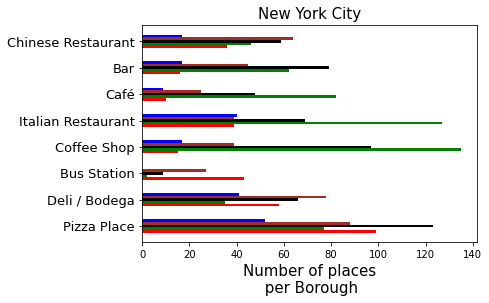

In [183]:
gs = gridspec.GridSpec(1, 1)
ax = plt.subplot(gs[0])

number_of_venues = np.arange(len(specific_venues))

colors = ['red','green','black','brown','yellow']
width=0.1
for i in range(len(number_of_venues)):
    ax.barh(number_of_venues[i] - 2*width, top_3[i][0], width, color = 'red', label = newyork['Borough'].unique()[0])
    ax.barh(number_of_venues[i] - width, top_3[i][1], width, color = 'green', label = newyork['Borough'].unique()[1])
    ax.barh(number_of_venues[i], top_3[i][2], width, color = 'black', label = newyork['Borough'].unique()[2])
    ax.barh(number_of_venues[i] + width, top_3[i][3], width, color = 'brown', label = newyork['Borough'].unique()[3])
    ax.barh(number_of_venues[i] + 2*width, top_3[i][4], width, color = 'blue', label = newyork['Borough'].unique()[4])
    

ax.set_yticks(number_of_venues)
ax.set_yticklabels(specific_venues,fontsize='13')
ax.set_xlabel('Number of places\n per Borough', fontsize=15)
ax.set_title('New York City', fontsize=15)

plt.show()

## Here I am searching for Greek and Turkish restaurants in New York, and I visualize in a map the result

In [182]:
greek, greek_latitude, greek_longitude = [], [], []
turkish, turkish_latitude, turkish_longitude = [], [], []
for i in range(len(newyork_boroughs_data)):
    y = newyork_boroughs_data[i]["Venue Category"]=="Greek Restaurant"
    l = 0
    for j in range(len(y.values)):
        if y.values[j]==True:
            greek_latitude.append(newyork_boroughs_data[i].iloc[j]["Venue Latitude"])
            greek_longitude.append(newyork_boroughs_data[i].iloc[j]["Venue Longitude"])
            l = l + 1
    greek.append(l)
    
    y = newyork_boroughs_data[i]["Venue Category"]=="Turkish Restaurant"
    l = 0
    for j in range(len(y.values)):
        if y.values[j]==True:
            turkish_latitude.append(newyork_boroughs_data[i].iloc[j]["Venue Latitude"])
            turkish_longitude.append(newyork_boroughs_data[i].iloc[j]["Venue Longitude"])
            l = l + 1
    turkish.append(l)


greek_and_turkish_restaurants_in_NY = folium.Map(location=[greek_latitude[0], greek_longitude[0]], zoom_start=10)

for lat, lng in zip(greek_latitude, greek_longitude):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color="blue",
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(greek_and_turkish_restaurants_in_NY)

for lat, lng in zip(turkish_latitude, turkish_longitude):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color="red",
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(greek_and_turkish_restaurants_in_NY) 

greek_and_turkish_restaurants_in_NY

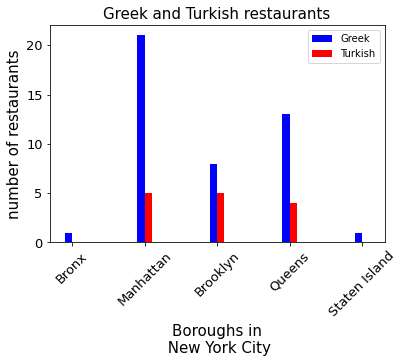

In [181]:
gs = gridspec.GridSpec(1, 1)
ax = plt.subplot(gs[0])

x = np.arange(5)

width=0.1
ax.bar(x - width/2, greek, width, color = 'blue', label = "Greek")
ax.bar(x + width/2, turkish, width, color = 'red', label = "Turkish")
ax.legend()

y = np.arange(0,25,5)
ax.set_yticks(y)
ax.set_yticklabels(y,fontsize=13)
ax.set_ylabel("number of restaurants", fontsize=15)
ax.set_xticks(x)
ax.set_xticklabels(newyork['Borough'].unique(),fontsize=13, rotation=45)
ax.set_xlabel('Boroughs in\n New York City', fontsize=15)
ax.set_title("Greek and Turkish restaurants", fontsize=15)

plt.show()

## Now I am doing the same analysis for Toronto. I start with some specific boroughs

In [221]:
CLIENT_ID = 'EX2QJNXTN1YYBYD2KWZLVRSEOZTA5BMSBXUOF0EEWYWE0HJ0' # your Foursquare ID
CLIENT_SECRET = 'BMSOX2F3H1XQVDPNQDAPKASAMFKQCUUGTTYWU4WBEF5O4JZJ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

toronto_boroughs_data = []

#'Downtown Toronto', "Queen's Park", 'East Toronto', 'West Toronto', , 'Central Toronto'
selected_neighborhoods_toronto = ['North York', 'East York', 'York','East York/East Toronto']

for x in selected_neighborhoods_toronto:
    manhattan_data = toronto[toronto['Borough'] == x].reset_index(drop=True)

    neighborhood_latitude = manhattan_data.loc[0, 'Latitude'] # neighborhood latitude value
    neighborhood_longitude = manhattan_data.loc[0, 'Longitude'] # neighborhood longitude value

    neighborhood_name = manhattan_data.loc[0, 'Neighborhood'] # neighborhood name

    print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

    LIMIT = 100
    radius = 500
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        neighborhood_latitude, 
        neighborhood_longitude, 
        radius, 
        LIMIT)

    results = requests.get(url).json()

    venues = results['response']['groups'][0]['items']
    
    nearby_venues = json_normalize(venues) # flatten JSON

    # filter columns
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    nearby_venues =nearby_venues.loc[:, filtered_columns]

    # filter the category for each row
    nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

    # clean columns
    nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
    venues = results['response']['groups'][0]['items']

    manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude'])

    #manhattan_venues.groupby('Neighborhood').count()
    #manhattan_venues.head()
    toronto_boroughs_data.append(manhattan_venues)

Latitude and longitude values of Parkwoods are 43.7532586, -79.3296565.


/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/ipykernel/__main__.py:37: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


Parkwoods
Victoria Village
Lawrence Manor, Lawrence Heights
Don Mills North
Glencairn
Don Mills South
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Fairview, Henry Farm, Oriole
Northwood Park, York University
Bayview Village
Downsview East
York Mills, Silver Hills
Downsview West
North Park, Maple Leaf Park, Upwood Park
Humber Summit
Willowdale, Newtonbrook
Downsview Central
Bedford Park, Lawrence Manor East
Humberlea, Emery
Willowdale South
Downsview Northwest
York Mills West
Willowdale West
Latitude and longitude values of Parkview Hill, Woodbine Gardens are 43.7063972, -79.309937.
Parkview Hill, Woodbine Gardens
Woodbine Heights
Leaside
Thorncliffe Park
Latitude and longitude values of Humewood-Cedarvale are 43.6937813, -79.42819140000002.
Humewood-Cedarvale
Caledonia-Fairbanks
Del Ray, Mount Dennis, Keelsdale and Silverthorn
Runnymede, The Junction North
Weston
Latitude and longitude values of The Danforth  East are 43.685347, -79.3381065.
The Danforth  East


In [222]:
specific_venues = toronto_boroughs_data[0]["Venue Category"].value_counts().keys()[:3].tolist()

for i in range(len(toronto_boroughs_data)):
    for x in toronto_boroughs_data[i]["Venue Category"].value_counts().keys()[:3].tolist():
        if x not in specific_venues:
            specific_venues.append(x)

top_3 = []
for x in specific_venues:
    b = []
    for i in range(len(toronto_boroughs_data)):
        for j in range(len(toronto_boroughs_data[i]["Venue Category"].value_counts().keys())):
            if x in toronto_boroughs_data[i]["Venue Category"].value_counts().keys():
                if x==toronto_boroughs_data[i]["Venue Category"].value_counts().keys()[j]:
                    b.append(toronto_boroughs_data[i]["Venue Category"].value_counts().values[j])
            else:
                b.append(0)
                break
                            
    top_3.append(b)
    
top_3

[[18, 4, 1, 0],
 [13, 0, 0, 0],
 [10, 2, 2, 1],
 [7, 4, 0, 0],
 [2, 3, 0, 0],
 [4, 0, 2, 1],
 [8, 2, 1, 0],
 [2, 3, 0, 1]]

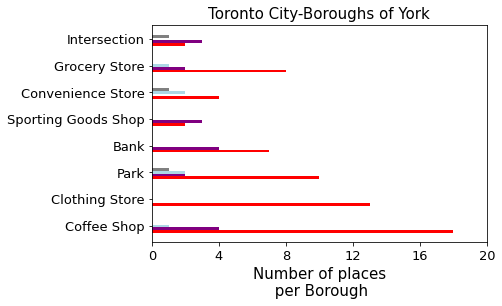

In [223]:
borough_colors = {"North York":"red",
                  "Downtown Toronto":"blue",
                  "Queen's Park":"green",
                  "Etobicoke":"black",
                  "Scarborough":"yellow",
                  "East York":"purple",
                  "York":"lightblue",
                  "East Toronto":"brown",
                  "West Toronto":"orange",
                  "East York/East Toronto":"grey",
                  "Central Toronto":"pink",
                  "Mississauga":"cyan",
                  "Downtown Toronto Stn A":"darkcyan",
                  "Etobicoke Northwest":"gold",
                  "East Toronto Business":"navy"}

gs = gridspec.GridSpec(1, 1)
ax = plt.subplot(gs[0])

number_of_venues = np.arange(len(specific_venues))

width=0.1
for i in range(len(number_of_venues)):
    ax.barh(number_of_venues[i] - 2*width, top_3[i][0], width, color = 'red', label = "North York")
    ax.barh(number_of_venues[i] - width, top_3[i][1], width, color = 'purple', label = "East York")
    ax.barh(number_of_venues[i], top_3[i][2], width, color = 'lightblue', label = "York")
    ax.barh(number_of_venues[i] + width, top_3[i][3], width, color = 'grey', label = "East York/East Toronto")
#    ax.barh(number_of_venues[i] + 2*width, top_3[i][4], width, color = 'blue', label = newyork['Borough'].unique()[4])
    
x = [0,4,8,12,16,20]
ax.set_xticks(x)
ax.set_xticklabels(x,fontsize='13')
ax.set_yticks(number_of_venues)
ax.set_yticklabels(specific_venues,fontsize='13')
ax.set_xlabel('Number of places\n per Borough', fontsize=15)
ax.set_title('Toronto City-Boroughs of York', fontsize=15)

plt.show()

In [228]:
CLIENT_ID = 'EX2QJNXTN1YYBYD2KWZLVRSEOZTA5BMSBXUOF0EEWYWE0HJ0' # your Foursquare ID
CLIENT_SECRET = 'BMSOX2F3H1XQVDPNQDAPKASAMFKQCUUGTTYWU4WBEF5O4JZJ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

toronto_boroughs_data = []

#'Downtown Toronto', "Queen's Park", 'East Toronto', 'West Toronto', , 'Central Toronto'
selected_neighborhoods_toronto = ['Downtown Toronto', "Queen's Park", 'East Toronto', 'West Toronto', 'Central Toronto']

for x in selected_neighborhoods_toronto:
    manhattan_data = toronto[toronto['Borough'] == x].reset_index(drop=True)

    neighborhood_latitude = manhattan_data.loc[0, 'Latitude'] # neighborhood latitude value
    neighborhood_longitude = manhattan_data.loc[0, 'Longitude'] # neighborhood longitude value

    neighborhood_name = manhattan_data.loc[0, 'Neighborhood'] # neighborhood name

    print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

    LIMIT = 100
    radius = 500
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        neighborhood_latitude, 
        neighborhood_longitude, 
        radius, 
        LIMIT)

    results = requests.get(url).json()

    venues = results['response']['groups'][0]['items']
    
    nearby_venues = json_normalize(venues) # flatten JSON

    # filter columns
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    nearby_venues =nearby_venues.loc[:, filtered_columns]

    # filter the category for each row
    nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

    # clean columns
    nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
    venues = results['response']['groups'][0]['items']

    manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude'])

    #manhattan_venues.groupby('Neighborhood').count()
    #manhattan_venues.head()
    toronto_boroughs_data.append(manhattan_venues)
    
specific_venues = toronto_boroughs_data[0]["Venue Category"].value_counts().keys()[:3].tolist()

for i in range(len(toronto_boroughs_data)):
    for x in toronto_boroughs_data[i]["Venue Category"].value_counts().keys()[:3].tolist():
        if x not in specific_venues:
            specific_venues.append(x)

top_3 = []
for x in specific_venues:
    b = []
    for i in range(len(toronto_boroughs_data)):
        for j in range(len(toronto_boroughs_data[i]["Venue Category"].value_counts().keys())):
            if x in toronto_boroughs_data[i]["Venue Category"].value_counts().keys():
                if x==toronto_boroughs_data[i]["Venue Category"].value_counts().keys()[j]:
                    b.append(toronto_boroughs_data[i]["Venue Category"].value_counts().values[j])
            else:
                b.append(0)
                break
                            
    top_3.append(b)
    
top_3

Latitude and longitude values of Regent Park, Harbourfront are 43.6542599, -79.3606359.


/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/ipykernel/__main__.py:37: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


Regent Park, Harbourfront
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Harbourfront East, Union Station, Toronto Islands
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
University of Toronto, Harbord
Kensington Market, Chinatown, Grange Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Rosedale
St. James Town, Cabbagetown
First Canadian Place, Underground city
Church and Wellesley
Latitude and longitude values of Ontario Provincial Government are 43.6623015, -79.3894938.
Ontario Provincial Government
Latitude and longitude values of The Beaches are 43.67635739999999, -79.2930312.
The Beaches
The Danforth West, Riverdale
India Bazaar, The Beaches West
Studio District
Latitude and longitude values of Dufferin, Dovercourt Village are 43.66900510000001, -79.4422593.
Dufferin, Dovercourt Village
Little Portugal, Trinity
Brockton, Parkdale Village,

[[109, 6, 6, 7, 8],
 [63, 2, 4, 11, 6],
 [40, 0, 2, 4, 3],
 [7, 2, 1, 4, 2],
 [3, 0, 7, 1, 1],
 [18, 1, 5, 6, 2],
 [18, 1, 1, 8, 0],
 [13, 1, 2, 1, 8],
 [15, 0, 3, 3, 6]]

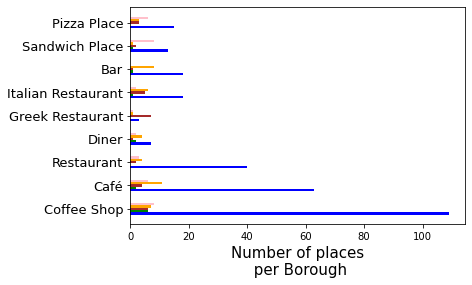

In [229]:
borough_colors = {"North York":"red",
                  "Downtown Toronto":"blue",
                  "Queen's Park":"green",
                  "Etobicoke":"black",
                  "Scarborough":"yellow",
                  "East York":"purple",
                  "York":"lightblue",
                  "East Toronto":"brown",
                  "West Toronto":"orange",
                  "East York/East Toronto":"grey",
                  "Central Toronto":"pink",
                  "Mississauga":"cyan",
                  "Downtown Toronto Stn A":"darkcyan",
                  "Etobicoke Northwest":"gold",
                  "East Toronto Business":"navy"}

gs = gridspec.GridSpec(1, 1)
ax = plt.subplot(gs[0])

number_of_venues = np.arange(len(specific_venues))

width=0.1
for i in range(len(number_of_venues)):
    ax.barh(number_of_venues[i] - 2*width, top_3[i][0], width, color = 'blue')
    ax.barh(number_of_venues[i] - width, top_3[i][1], width, color = 'green')
    ax.barh(number_of_venues[i], top_3[i][2], width, color = 'brown')
    ax.barh(number_of_venues[i] + width, top_3[i][3], width, color = 'orange')
    ax.barh(number_of_venues[i] + 2*width, top_3[i][4], width, color = 'pink')
    
#x = [0,4,8,12,16,20]
#ax.set_xticks(x)
#ax.set_xticklabels(x,fontsize='13')
ax.set_yticks(number_of_venues)
ax.set_yticklabels(specific_venues,fontsize='13')
ax.set_xlabel('Number of places\n per Borough', fontsize=15)
plt.show()

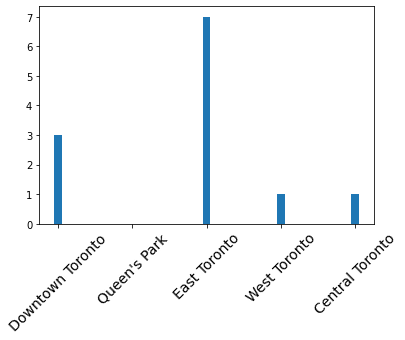

In [235]:
gs = gridspec.GridSpec(1, 1)
ax = plt.subplot(gs[0])

selected_neighborhoods_toronto = ['Downtown Toronto', "Queen's Park", 'East Toronto', 'West Toronto', 'Central Toronto']
x = np.arange(5)

width=0.1
ax.bar(x, top_3[4], width)

ax.set_xticks(x)
ax.set_xticklabels(selected_neighborhoods_toronto, fontsize=14, rotation=45)
plt.show()